# Implementación 
### Equipo: 

In [1]:
# Importación de librerías
import json
import pandas as pd
import numpy as np
import missingno as msgno
import matplotlib.pyplot as plt
from ml_classes import PrepML, MLModel
from matplotlib.pyplot import rcParams
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Parámetros generales para plots
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 8
# Semilla pseudo-aleatoria
rd_seed = 1234

# 0. Obtener la información

# 1. Creación del Dataset 

## 1.1 Bases Originales

In [3]:
# Importación de las bases para muestras de entrenamiento y prueba
df_train = pd.read_csv('bases/true_cars_train.csv',delimiter=";")
df_test = pd.read_csv('bases/true_cars_test.csv',delimiter=";")
# Dimensiones de las bases
print(f'Base Train: {df_train.shape}\nBase Test: {df_test.shape}')

Base Train: (639145, 8)
Base Test: (212977, 8)


In [4]:
# Información general de muestra de entrenamiento
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639145 entries, 0 to 639144
Data columns (total 8 columns):
Price      639145 non-null int64
Year       639145 non-null int64
Mileage    639145 non-null int64
City       639145 non-null object
State      639145 non-null object
Vin        639145 non-null object
Make       639145 non-null object
Model      639145 non-null object
dtypes: int64(3), object(5)
memory usage: 39.0+ MB


In [5]:
# Creación de atributo 'sample'
df_train['sample'] = 'train'
df_test['sample'] = 'test'

In [6]:
# Unión de ambas bases
df_data = pd.concat([df_train, df_test])
print(f'Base Data: {df_data.shape}')

Base Data: (852122, 9)


## 1.2 Base API

In [7]:
# Importación de la base extraída por el requerimiento a la api
df_api = pd.read_csv('bases/api_features.csv').drop(columns='Unnamed: 0')
print(f'Base API: {df_api.shape}')

Base API: (846562, 29)


In [8]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846562 entries, 0 to 846561
Data columns (total 29 columns):
AirBagLocFront              797265 non-null object
BodyClass                   845535 non-null object
BusFloorConfigType          843524 non-null object
BusType                     843524 non-null object
CustomMotorcycleType        846525 non-null object
DisplacementCC              839096 non-null float64
DisplacementCI              839096 non-null float64
DisplacementL               839096 non-null float64
Doors                       739918 non-null float64
EngineCylinders             735744 non-null object
EngineHP                    380764 non-null object
EngineKW                    380764 non-null object
ErrorCode                   846550 non-null object
ErrorText                   846550 non-null object
FuelTypePrimary             789859 non-null object
Make                        846525 non-null object
Manufacturer                846525 non-null object
ManufacturerId    

In [9]:
# Identificar columnas con solo valores "Not Applicable" 
notapp_series = df_api\
                    .isin(['Not Applicable'])\
                    .sum()
cols2drop = list(notapp_series[notapp_series > 1].index)

In [10]:
# Identificar columnas con más de un 15% de datos perdidos
null_series = df_api\
                .isnull()\
                .sum()\
                /df_api.shape[0] 
cols2drop += list(null_series[null_series > .15].index)

In [11]:
# Columnas repetidas en la data original
cols2drop += ['ModelYear', 'Make']

In [12]:
# Borrar aquellas columnas 
df_api = df_api.drop(columns=cols2drop)
print(f'Base API: {df_api.shape}')

Base API: (846562, 16)


In [13]:
df_api=df_api.rename(columns={"AirBagLocFront":"Airag_LocFront",
                        "BodyClass":"d_Body_Class",
                        "DisplacementCC":"d_DisplacementCC",
                        "DisplacementCI":"d_DisplacementCI",
                        "DisplacementL":"d_DisplacementL",
                        "Doors":"d_Doors",
                        "EngineCylinders ":"d_EngineCylinders",
                        "EngineHP":"d_EngineHP",
                        "EngineKW":"d_EngineKW",
                        "ErrorCode":"d_ErrorCode",
                        "ErrorText":"d_ErrorText",
                        "FuelTypePrimary":"d_FuelTypePrimary",
                        "Make":"d_Make",
                        "Manufacturer":"d_Manufacturer",
                        "ManufacturerId":"d_ManufacturerId",
                        "Model":"d_Model",
                        "ModelYear":"d_ModelYear",
                        "PlantCity":"d_PlantCity",
                        "PlantCountry":"d_PlantCountry",
                        "TPMS":"d_TPMS",
                        "VIN":"Vin",
                        "VehicleType":"d_VehicleType"})

## 1.3 Unión de Bases

In [14]:
# Unión de bases
df = pd.merge(left=df_data, 
              right=df_api, 
              how='inner',
              on='Vin')
# Dimensiones de la base
print(f'Dataset: {df.shape}')

Dataset: (846644, 24)


In [15]:
# Información general de la base
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 846644 entries, 0 to 846643
Data columns (total 24 columns):
Price                846644 non-null int64
Year                 846644 non-null int64
Mileage              846644 non-null int64
City                 846644 non-null object
State                846644 non-null object
Vin                  846644 non-null object
Make                 846644 non-null object
Model                846644 non-null object
sample               846644 non-null object
Airag_LocFront       797359 non-null object
d_Body_Class         845629 non-null object
d_DisplacementCC     839190 non-null float64
d_DisplacementCI     839190 non-null float64
d_DisplacementL      839190 non-null float64
d_Doors              740010 non-null float64
EngineCylinders      735838 non-null object
d_ErrorCode          846644 non-null object
d_ErrorText          846644 non-null object
d_FuelTypePrimary    789951 non-null object
d_Manufacturer       846619 non-null object
d_Manufa

In [16]:
#df['d_ErrorText'].value_counts()

# 2. Análisis exploratorio de datos

## 2.1 Análisis de los datos perdidos

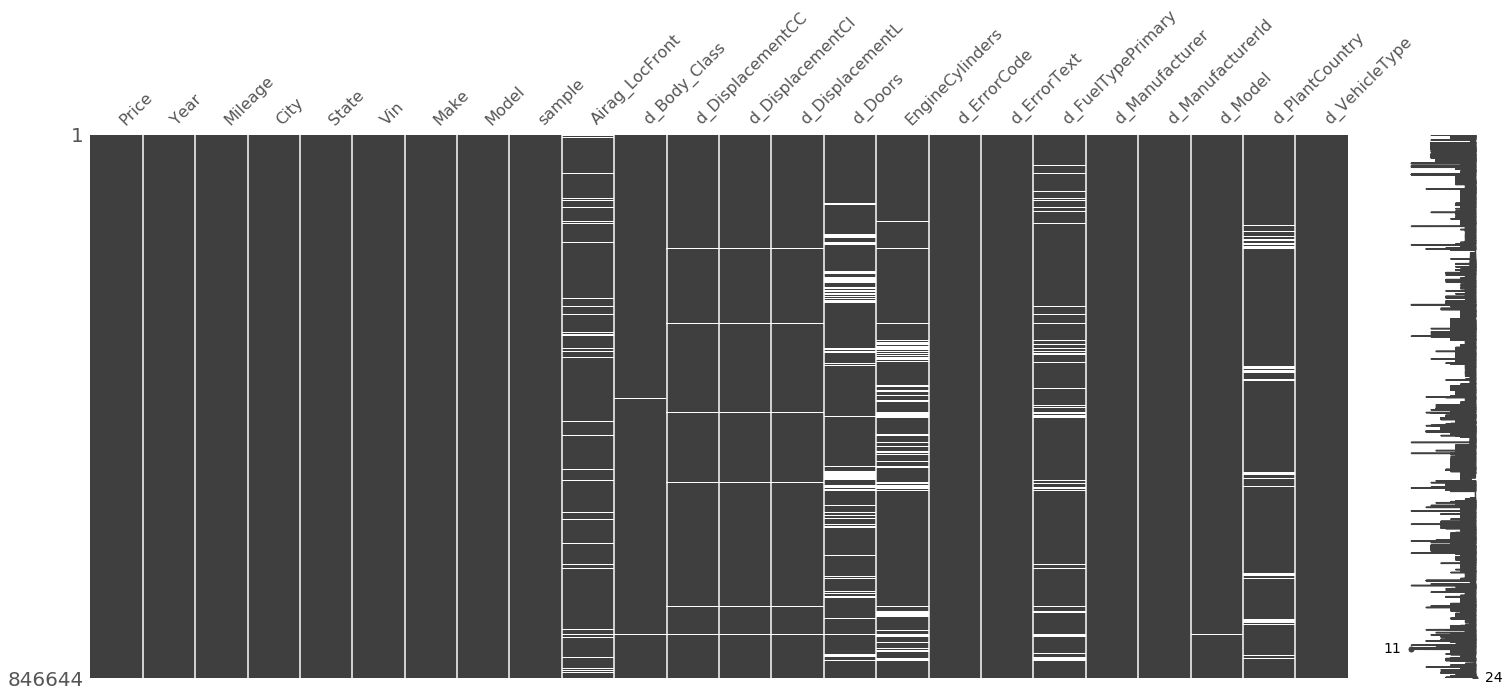

In [17]:
msgno.matrix(df)

# 3. Preproceso

In [18]:
# Selección de variables para modelos
df_select = df.loc[:, ['Price', 'Model', 'Mileage', 'sample']]

In [19]:
# Muestra aleatoria
#df_sample = df_select.sample(2000).reset_index(drop=True)

In [20]:
# Instanciar clase para realizar preproceso
df_prep = PrepML(df_select)

In [ ]:
# Realizamos OneHot Encoder a las columnas categóricas seleccionadas
df_prep.one_hot_encoder(['Model'])

In [ ]:
# Removemos outliers (opcional)
#df_prep.remove_outliers(['Price', 'Mileage'], multiplier=1.5)

In [ ]:
# Estandarizamos variables continuas seleccionadas
df_prep.standard_scaler(['Price', 'Mileage'])

In [ ]:
# Separar muestras según
X_train, y_train, X_test, y_test = df_prep.to_train_test_samples('sample', 'Price')

# 4.Modelamiento 

## 4.1 LightGBM

In [ ]:
# Establecemos parámetros a evaluar en el modelo
lgb_grid = {'max_depth': [3, 4, 5, 6], 
            'n_estimators': [50, 60, 70, 80],
            'num_leaves': [30, 50, 70, 80]}
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
lgb_reg = MLModel(model=LGBMRegressor(n_jobs=-1,
                                      random_state=rd_seed))
# Implementación del grid search
lgb_reg.grid_search(X_train,
                    y_train,
                    param_grid=lgb_grid,
                    cv=5)

In [ ]:
lgb_reg.metrics(X_test, y_test)

## 4.2 XGBoost

In [ ]:
# Establecemos parámetros a evaluar en el modelo
xgb_grid = {'max_depth': [3, 4, 5, 6], 
            'n_estimators': [50, 60, 70, 80]}
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
xgb_reg = MLModel(model=XGBRegressor(n_jobs=-1,
                                     seed=rd_seed))
# Implementación del grid search
xgb_reg.grid_search(X_train,
                    y_train,
                    param_grid=xgb_grid,
                    cv=5)

In [ ]:
# Métricas
xgb_reg.metrics(X_test, y_test)

In [ ]:
xgb_reg.best_model

In [ ]:
xgb_reg.feature_importances(X_train)

## 4.3 RandomForest

In [ ]:
# Establecemos parámetros a evaluar en el modelo
rf_grid = {'n_estimators': [500, 600, 700], 
           'max_depth': [5, 9, 12, 13], 
           'oob_score': [True]}
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
rf_reg = MLModel(model=RandomForestRegressor(n_jobs=-1,
                                             random_state=rd_seed))
# Implementación del grid search
rf_reg.grid_search(X_train,
                    y_train,
                    param_grid=rf_grid,
                    cv=5)

In [ ]:
rf_reg.metrics(X_test, y_test)